In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, cohen_kappa_score, mean_absolute_error, mean_squared_error, make_scorer, accuracy_score, roc_curve, auc
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.preprocessing import normalize
from catboost import CatBoostClassifier, Pool, cv, CatBoostRegressor
from glob import glob

from itertools import chain
from seaborn import heatmap
import ntpath, json

warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from scipy import interp
from itertools import cycle

In [52]:
#taken almost as it is from Sklearn documentation
def plot_roc(name, model):
    
    #model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)
    
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(5):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= 5

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(12,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'brown', 'red'])
    for i, color in zip(range(5), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.show()

In [41]:
def get_score(model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return round(cohen_kappa_score(predictions, y_test, weights="quadratic"),3)

In [42]:
class MyPreProcess(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
        
    def fit( self, X, y = None  ):
        #print(X.columns)
        self.biggest_breeds_1 = list(X.Breed1.value_counts(normalize=True)[X.Breed1.value_counts(normalize=True)>0.1].index)
        self.biggest_breeds_2 = list(X.Breed2.value_counts(normalize=True)[X.Breed2.value_counts(normalize=True)>0.1].index)
        #return self
        
    def _classify_breed_1(self, breed):
        if breed in self.biggest_breeds_1:
            return breed
        return -1
    
    def _classify_breed_2(self, breed):
        if breed in self.biggest_breeds_2:
            return breed
        return -1
        
    def transform(self, X , y = None ):
        X_copy = X.copy()
        X_copy["BigBreed1"] = X_copy.Breed1.apply(self._classify_breed_1)
        X_copy["BigBreed2"] = X_copy.Breed2.apply(self._classify_breed_2)
        X_copy["IsMixed"] = X_copy.Breed2.map(lambda x: 0 if x==0 else 1)
        X_copy["NameLen"] = X_copy.Name.str.len()
        X_copy["DescriptionLen"] = X_copy.Description.str.len()
        return X_copy

In [5]:
def get_pet_id(path):
    file_name = ntpath.basename(path)
    end = file_name.rfind('.json')
    return file_name[:end]

In [6]:
import os.path
def get_sentiment_df(folder):
    df = pd.DataFrame(columns = ["PetID", "SentimentMagnitude", "SentimentScore"])
    i=0
    pattern = os.path.join(folder, '*.json')
    for file_name in glob(pattern):
        with open(file_name, encoding="utf8", errors="ignore") as json_file:
            data = json.load(json_file)
            sentiment = data["documentSentiment"]
            df.loc[i] = [get_pet_id(file_name), sentiment["magnitude"], sentiment["score"]]
            i+=1
    return df

In [7]:
@ignore_warnings(category=ConvergenceWarning)
def print_scores(models):
    for name, model in models:
        print("<<<<----------------------------------------------------------------------------->>>>")
        print(name)
        print("Quadratic weighted kappa score:", get_score(model))

In [8]:
MODELS = [
        ('KNN', KNeighborsClassifier()),
        ('Decision Tree', DecisionTreeClassifier(random_state=1)),
        ('Random Forest', RandomForestClassifier(random_state=1)),
        ('AdaBoost', AdaBoostClassifier(random_state=1)),
        ('GradientBoost', GradientBoostingClassifier(random_state=1)),
        ('CatBoost', CatBoostClassifier(verbose=False)),
        ('Logistic Regression', LogisticRegression())
        ]

In [9]:
train = pd.read_csv("train/train.csv")
test = pd.read_csv("test/test.csv")

In [10]:
try:
    train_sentiment_df = pd.read_csv("train_sentiment.csv")
    test_sentiment_df = pd.read_csv("test_sentiment.csv")
except IOError:
    train_sentiment_df = get_sentiment_df('train_sentiment')
    test_sentiment_df = get_sentiment_df('test_sentiment')
    train_sentiment_df.to_csv("train_sentiment.csv", index=False)
    test_sentiment_df.to_csv("test_sentiment.csv", index=False)

In [11]:
train = pd.merge(train, train_sentiment_df, how="left")
test = pd.merge(test, test_sentiment_df, how="left")

In [12]:
X = train.drop(columns="AdoptionSpeed")
y = train.AdoptionSpeed

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, stratify=y)

In [14]:
cat_features = X_train.select_dtypes("object").columns

In [15]:
mpp = MyPreProcess()
mpp.fit(X_train)
X_train = mpp.transform(X_train).drop(columns=cat_features)
X_test = mpp.transform(X_test).drop(columns=cat_features)

In [16]:
si = SimpleImputer()
si.fit(X_train[["SentimentMagnitude", "SentimentScore"]])
X_train[["SentimentMagnitude", "SentimentScore"]] = si.transform(X_train[["SentimentMagnitude", "SentimentScore"]]).round(1)
X_test[["SentimentMagnitude", "SentimentScore"]] = si.transform(X_test[["SentimentMagnitude", "SentimentScore"]]).round(1)

In [17]:
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [19]:
new_columns = ['SentimentMagnitude', 'SentimentScore', 'BigBreed1', 'BigBreed2', 'IsMixed', 'NameLen']

new_features_df = X_train.append(X_test).sort_index()[new_columns]

new_features_df["PetID"] = train["PetID"]

new_features_df.to_csv("new_features.csv", index=False)

In [20]:
X_train = pd.get_dummies(X_train, columns=["State", "Type", "Color1", "Color2", "Color3"])
X_test = pd.get_dummies(X_test, columns=["State", "Type", "Color1", "Color2", "Color3"])

In [25]:
print_scores(MODELS)

<<<<----------------------------------------------------------------------------->>>>
KNN
Quadratic weighted kappa score: 0.155
<<<<----------------------------------------------------------------------------->>>>
Decision Tree
Quadratic weighted kappa score: 0.193
<<<<----------------------------------------------------------------------------->>>>
Random Forest
Quadratic weighted kappa score: 0.376
<<<<----------------------------------------------------------------------------->>>>
AdaBoost
Quadratic weighted kappa score: 0.326
<<<<----------------------------------------------------------------------------->>>>
GradientBoost
Quadratic weighted kappa score: 0.368
<<<<----------------------------------------------------------------------------->>>>
CatBoost
Quadratic weighted kappa score: 0.38
<<<<----------------------------------------------------------------------------->>>>
Logistic Regression
Quadratic weighted kappa score: 0.154


We'll try now with an ensemble of all those, with Logistic Regression as the final estimator, to see if it improves the score.

In [27]:
clf = StackingClassifier(
    estimators=MODELS,
    final_estimator=LogisticRegression()
)
print_scores([('ensemble', clf)])

<<<<----------------------------------------------------------------------------->>>>
ensemble
Quadratic weighted kappa score: 0.391


And we indeed see a not-neglectable improvement.

In [28]:
MODELS.append(('ensemble', clf))

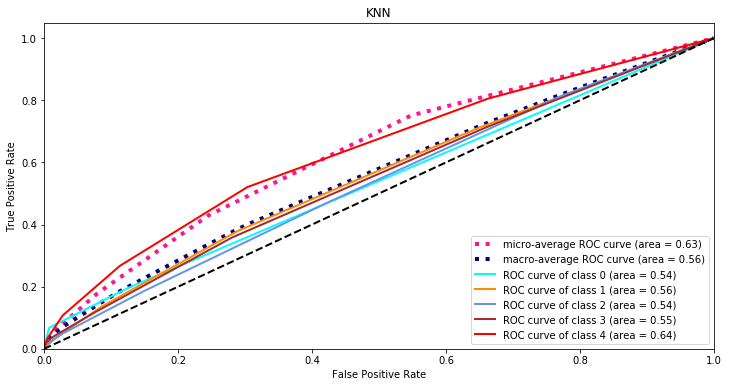

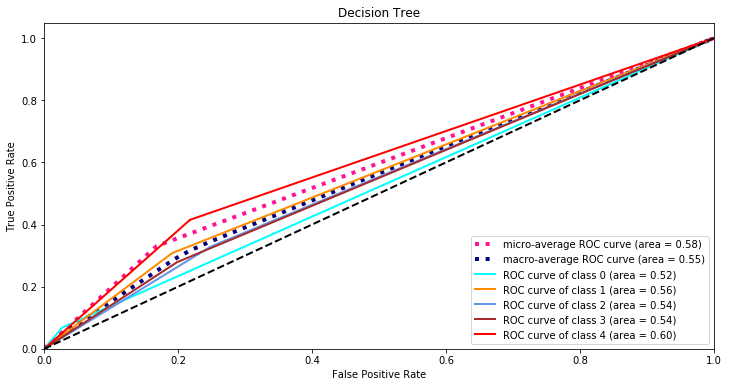

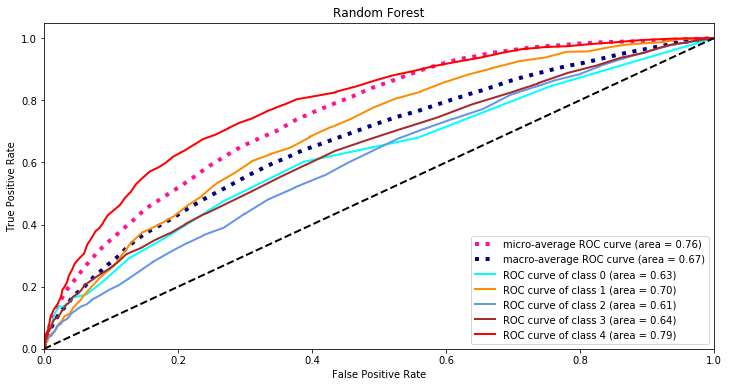

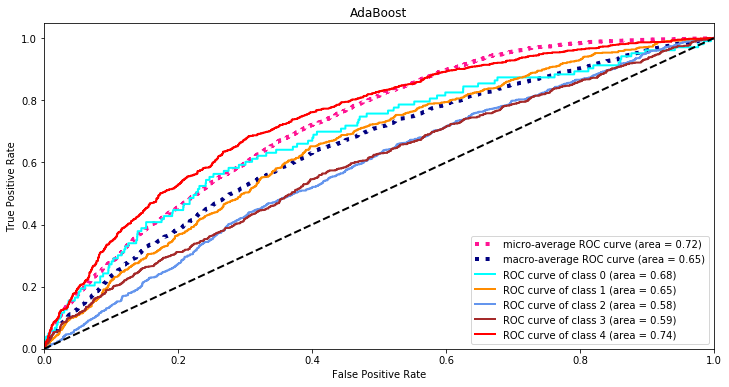

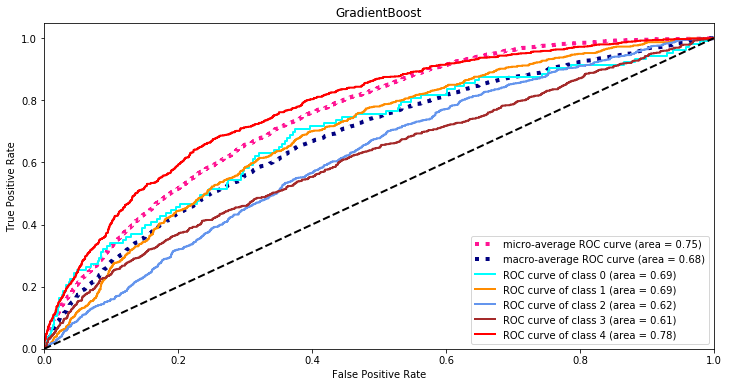

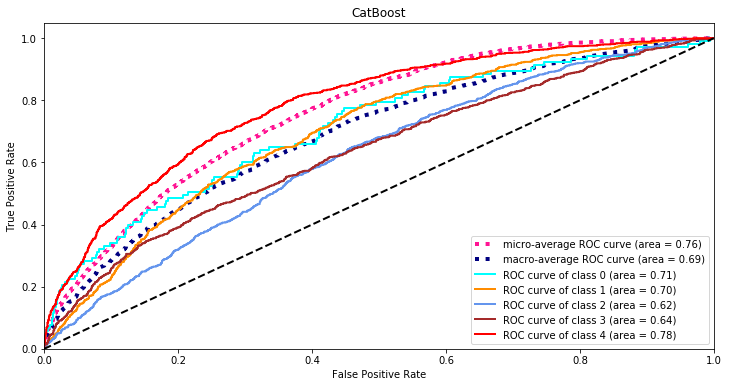

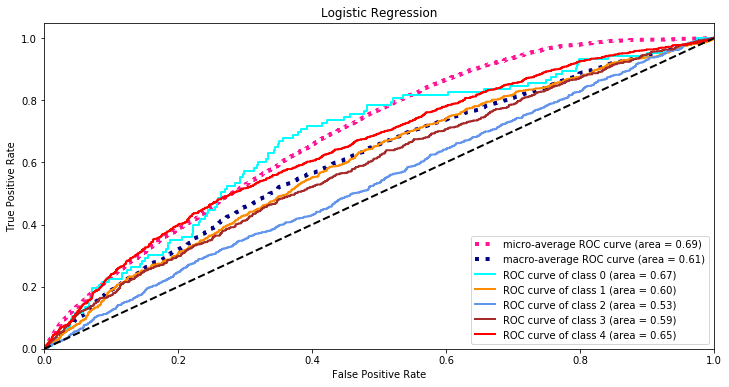

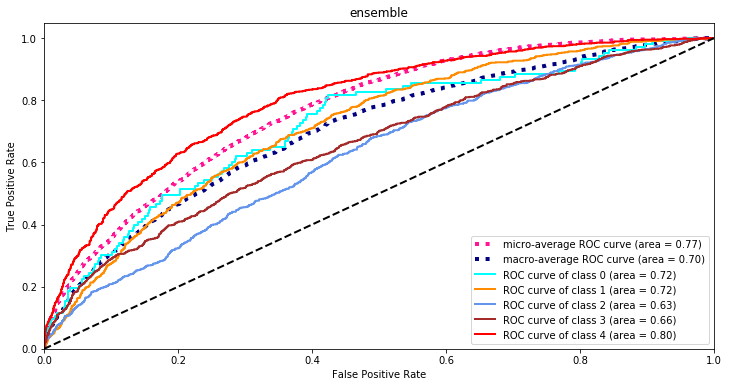

In [53]:
for name, model in MODELS:
    plot_roc(name, model)